In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import graphviz

## 泰坦尼克号预测存活
### 数据预处理

In [82]:
df = pd.read_csv('./taitanic_data/data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 去无用特征
【01】、Pclass（客舱等级）   
【02】、Name（乘客姓名） :头衔可能有分析价值，但暂时不分析  
【03】、Sex（性别）  
【04】、Age（乘客年龄）   
【05】、SibSP（在船上兄弟姐妹/配偶数）   
【06】、Parch（在船上父母/子女数量）  
【07】、Ticket（票号）：无法分类，没有参考价值   
【08】、Fare（票价）：票价由客舱等级决定，不必重复分析  
【09】、Cabin（客舱号）:缺失值太多，没有分析价值   
【10】、Embarked（登船港口）   


#### 缺失值处理
缺失值过多则舍弃特征；   
少量缺失值：
+ 取均值填充（产生了噪音点）
+ 删除缺失值

In [83]:
df.drop(['PassengerId','Name','Ticket', 'Fare', 'Cabin'], axis=1, inplace=True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,S
887,1,1,female,19.0,0,0,S
888,0,3,female,NaN,1,2,S
889,1,1,male,26.0,0,0,C


In [84]:
# 删除Embarked缺失的样本
df['Age'] = df['Age'].fillna(df['Age'].mean())   #填充
df.dropna(axis=0, inplace=True)     #删除有缺失值的行
df.reset_index(drop=True, inplace=True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.000000,1,0,S
1,1,1,female,38.000000,1,0,C
2,1,3,female,26.000000,0,0,S
3,1,1,female,35.000000,1,0,S
4,0,3,male,35.000000,0,0,S
...,...,...,...,...,...,...,...
884,0,2,male,27.000000,0,0,S
885,1,1,female,19.000000,0,0,S
886,0,3,female,29.699118,1,2,S
887,1,1,male,26.000000,0,0,C


In [85]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [86]:

# 分割出标签
y_data = df['Survived']
x_data = df.drop(['Survived'], axis=1)
# 编码
enc = OneHotEncoder(dtype=int)
result = enc.fit_transform( x_data[['Sex','Embarked']]).toarray()
print(enc.categories_)
print(enc.feature_names_in_) #参与one-hot编码的特征名字
code_df = pd.DataFrame(result)
print(code_df)
column_names = enc.get_feature_names_out()
column_names


[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]
['Sex' 'Embarked']
     0  1  2  3  4
0    0  1  0  0  1
1    1  0  1  0  0
2    1  0  0  0  1
3    1  0  0  0  1
4    0  1  0  0  1
..  .. .. .. .. ..
884  0  1  0  0  1
885  1  0  0  0  1
886  1  0  0  0  1
887  0  1  1  0  0
888  0  1  0  1  0

[889 rows x 5 columns]


array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype=object)

In [88]:
#拼接、换列名
x_data_new = pd.concat([x_data, code_df], axis=1)
x_data_new.drop(columns=enc.feature_names_in_,inplace=True)
keys = range(column_names.shape[0])
x_data_new.rename(columns=dict(zip(keys, column_names)), inplace=True)
x_data_new

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.000000,1,0,0,1,0,0,1
1,1,38.000000,1,0,1,0,1,0,0
2,3,26.000000,0,0,1,0,0,0,1
3,1,35.000000,1,0,1,0,0,0,1
4,3,35.000000,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
884,2,27.000000,0,0,0,1,0,0,1
885,1,19.000000,0,0,1,0,0,0,1
886,3,29.699118,1,2,1,0,0,0,1
887,1,26.000000,0,0,0,1,1,0,0


### 调试超参
网格搜索

In [122]:
# 划分测试集
x_data = x_data_new
x_train,x_test, y_train,y_test = train_test_split(x_data, y_data, test_size=0.3)

In [123]:
# 初步训练结果
clf = DecisionTreeClassifier(random_state=2)
clf.fit(x_train,y_train)
clf.score(x_test,y_test)

0.797752808988764

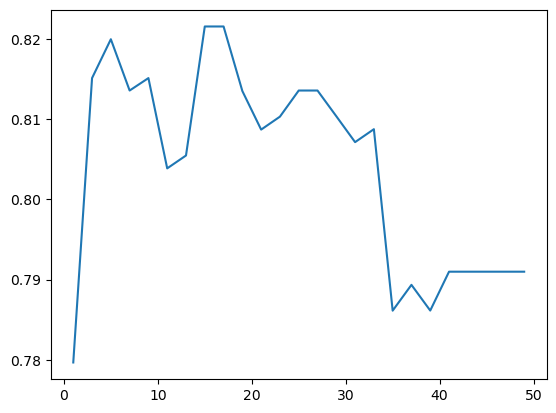

In [124]:
# 交叉验证，认识单个最佳参数
scores = []
scope = list(range(1,50,2))
for i in scope:
    clf = DecisionTreeClassifier(random_state=2,  min_samples_leaf=i)
    score_mean = cross_val_score(clf, x_train, y_train).mean()
    scores.append(score_mean)
plt.plot(scope, scores)
for n,score in zip(scope,scores):
    if score > 0.83:
        print(f'>0.83的min_samples_leaf：{n}')

In [125]:
#调超参
param_grid = {
    'max_depth':[*range(5,16)],
    'criterion':['gini', 'entropy'],
    'min_samples_leaf': [*range(1,30,2)],
    'splitter':['best','random']
}
clf = DecisionTreeClassifier(random_state=2)
GS = GridSearchCV(clf, param_grid)
GS.fit(x_train, y_train)

print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5, 'splitter': 'best'}
0.8328


In [134]:
# 使用最佳参数，训练建模
clf = DecisionTreeClassifier(random_state=2, criterion='entropy',max_depth=7, 
                             min_samples_leaf=7, splitter='best' ) 
            # 网格搜索得到的参数不一定最优，很大程度上依赖训练集和测试集
clf.fit(x_train,y_train)
clf.score(x_test,y_test)
# 结果准确率提升了 0.764-0.745

0.8127340823970037

In [100]:
# clf中标签 0,1顺序
print(y_train.unique())

[0 1]


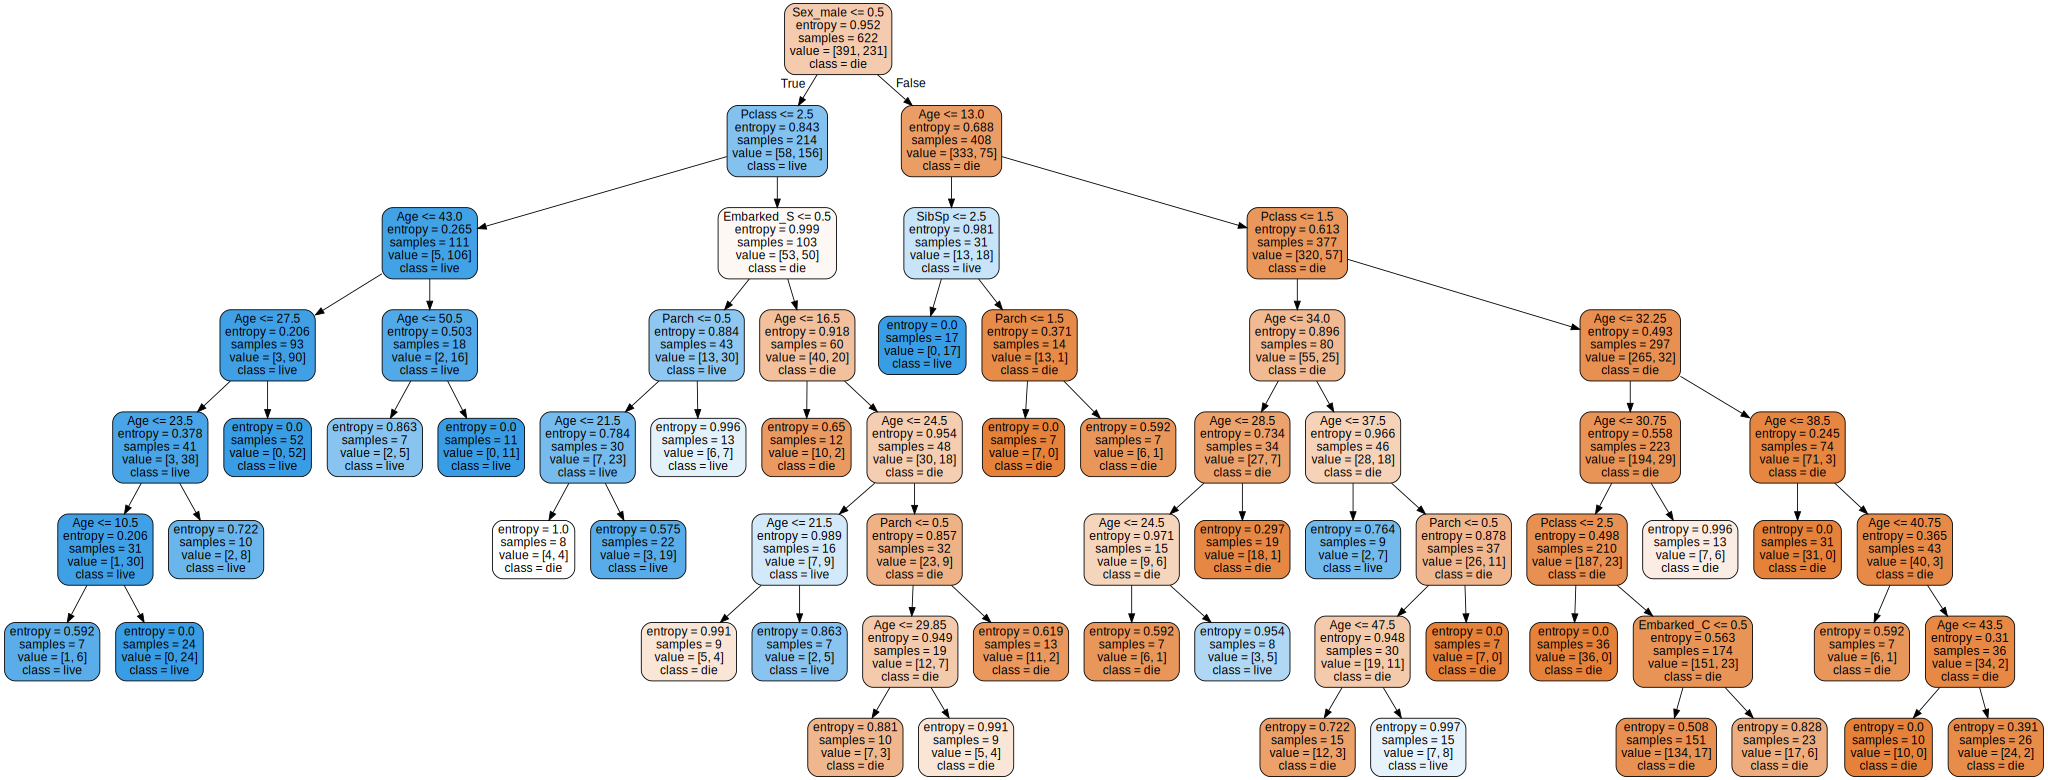

In [121]:
# 画出模型
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=['Pclass','Age','SibSp','Parch',
                                              'Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S'],
                                class_names=["die","live"],
                                filled=True, rounded=True) 
# print(dot_data) #digraph Tree 对象，存储了树信息
graph = graphviz.Source(dot_data) 
graph #输出图
# graph.render() #输出pdf